######################################

# Blood glucode prediction with 1h delay

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import random as python_random
import tensorflow as tf




2024-10-22 19:21:23.493430: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 19:21:23.502257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 19:21:23.512787: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 19:21:23.515915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 19:21:23.524137: I tensorflow/core/platform/cpu_feature_guar

## Data loading

In [2]:
# load the training data
train = pd.read_csv('data/train.csv')
test = pd.read_csv("data/test.csv")


/tmp/ipykernel_40585/468345928.py:2: DtypeWarning: Columns (435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/train.csv')


Convert the time data into a readable format

## Data descriptive statistics

In [3]:
# get the number of patients
print("Number of patients : ")
print(len(train['p_num'].unique()))
print("patient ids : ", train['p_num'].unique())

# number of measurements per patient
print("Number of measurements per patient : ")
print(train['p_num'].value_counts())


Number of patients : 
9
patient ids :  ['p01' 'p02' 'p03' 'p04' 'p05' 'p06' 'p10' 'p11' 'p12']
Number of measurements per patient : 
p_num
p03    26028
p02    25872
p10    25454
p12    25299
p04    24686
p11    24555
p01     8459
p06     8383
p05     8288
Name: count, dtype: int64


The number of measures per patient is not the same : data are not properly balanced.

In [4]:
# get the number of missing values
print("Number of missing values : ")
print(train.isnull().sum())
percentages = train.isnull().sum() / train.shape[0] * 100
print("Percentage of missing values : ")
print(percentages)


print("nb of NaN in each session")
nan_counts_per_session = train.isnull().sum(axis=1)
nan_counts_per_session.head()


Number of missing values : 
id                    0
p_num                 0
time                  0
bg-5:55           27254
bg-5:50           18491
                  ...  
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
bg+1:00               0
Length: 508, dtype: int64
Percentage of missing values : 
id                0.000000
p_num             0.000000
time              0.000000
bg-5:55          15.395653
bg-5:50          10.445476
                   ...    
activity-0:15    98.457271
activity-0:10    98.453882
activity-0:05    98.444844
activity-0:00    98.453882
bg+1:00           0.000000
Length: 508, dtype: float64
nb of NaN in each session


0    408
1    408
2    408
3    408
4    408
dtype: int64

In [5]:
# get the different times of measurements
print("Different times of measurements : ")
print(len(train['time'].unique()))
print(train['time'].unique())


Different times of measurements : 
288
['06:10:00' '06:25:00' '06:40:00' '06:55:00' '07:10:00' '07:25:00'
 '07:40:00' '07:55:00' '08:10:00' '08:25:00' '08:40:00' '08:55:00'
 '09:10:00' '09:25:00' '09:40:00' '09:55:00' '10:10:00' '10:25:00'
 '10:40:00' '10:55:00' '11:10:00' '11:25:00' '11:40:00' '11:55:00'
 '12:10:00' '12:25:00' '12:45:00' '13:00:00' '13:15:00' '13:30:00'
 '13:45:00' '14:00:00' '14:15:00' '14:30:00' '14:40:00' '15:00:00'
 '15:15:00' '15:30:00' '15:45:00' '16:00:00' '16:15:00' '16:30:00'
 '16:45:00' '17:00:00' '17:15:00' '17:30:00' '17:45:00' '18:00:00'
 '18:15:00' '18:30:00' '18:45:00' '19:00:00' '19:15:00' '19:30:00'
 '19:45:00' '20:00:00' '20:15:00' '20:30:00' '20:45:00' '21:00:00'
 '21:15:00' '21:30:00' '21:45:00' '22:00:00' '22:20:00' '22:35:00'
 '22:50:00' '23:05:00' '23:20:00' '23:35:00' '23:50:00' '00:05:00'
 '00:20:00' '00:35:00' '00:50:00' '01:05:00' '01:20:00' '01:35:00'
 '01:50:00' '02:05:00' '02:20:00' '02:35:00' '02:50:00' '03:05:00'
 '03:20:00' '03:35:00' 

The is continious measures for all of the patients : every five minutes during 24h. 
But, there is a lot of missing values. 

How to handle the NA?

- do data imputation? 
- remove the other time frame? 

In [6]:
train.describe()

,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,...,cals-0:40,cals-0:35,cals-0:30,cals-0:25,cals-0:20,cals-0:15,cals-0:10,cals-0:05,cals-0:00,bg+1:00
count,149770.000000,158533.000000,163364.000000,149766.000000,158254.000000,163770.000000,149763.000000,157973.000000,164174.000000,149771.000000,...,141694.000000,141706.000000,141713.000000,141722.000000,141732.000000,141741.000000,141751.000000,141761.000000,141767.000000,177024.000000
mean,8.211018,8.230449,8.253291,8.210988,8.229649,8.254083,8.211049,8.228888,8.254602,8.211000,...,9.364063,9.364096,9.362525,9.366591,9.368108,9.366998,9.370010,9.372536,9.368960,8.277045
std,2.852188,2.913438,2.945594,2.852090,2.911313,2.947651,2.852212,2.909304,2.949689,2.852315,...,8.012264,8.012681,8.017508,8.018465,8.018349,8.023788,8.021999,8.023280,8.023327,2.996398
min,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,...,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,2.200000
25%,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,...,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,6.100000
50%,7.600000,7.600000,7.700000,7.600000,7.600000,7.700000,7.600000,7.600000,7.700000,7.600000,...,6.180000,6.180000,6.170000,6.180000,6.180000,6.180000,6.180000,6.180000,6.180000,7.700000
75%,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,...,9.060000,9.060000,9.050000,9.060000,9.060000,9.060000,9.060000,9.070000,9.060000,9.900000
max,22.200000,25.100000,27.800000,22.200000,25.100000,27.800000,22.200000,25.100000,27.800000,22.200000,...,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,27.800000


# Handle missing values

remove sessions with empty insulin values

Impute the missing values

do encoding of exercice

remove heart rate values.


### Remove columns with no insulin values : 

In [7]:
# print(f"train dataset initial: {train.shape}")

# # Find the columns that contain the word 'insulin'
# insulin_cols = [col for col in train.columns if 'insulin' in col]
# print(insulin_cols)

# # Filter out the rows where all insulin columns are all NaN
# train.dropna(subset=insulin_cols, inplace=True, how="all")


# print(f"train dataset filted: {train.shape}")

# ######## test set
# print(f"test dataset initial: {test.shape}")

# # Find the columns that contain the word 'insulin'
# insulin_cols = [col for col in test.columns if 'insulin' in col]
# print(insulin_cols)

# # Filter out the rows where all insulin columns are all NaN
# test.dropna(subset=insulin_cols, inplace=True, how="all")


# print(f"test dataset filted: {test.shape}")


### Impute missing values for blood glucose :

In [8]:
def fill_na_with_linear_interpolation(df, prefixe):
    # Filter out all columns containing ‘bg’
    cols = [col for col in df.columns if col.startswith(prefixe)]
    
    # Linearly interpolate each row   
    df[cols] = df[cols].interpolate(method='linear', axis=1, limit_direction='both')
    
    return df

In [9]:
bg_cols = [col for col in train.columns if 'bg' in col]
print(bg_cols)

print(train[bg_cols].isnull().sum())



##### test set
bg_cols = [col for col in test.columns if 'bg' in col]
print(bg_cols)

print(test[bg_cols].isnull().sum())

['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30', 'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10', 'bg-5:05', 'bg-5:00', 'bg-4:55', 'bg-4:50', 'bg-4:45', 'bg-4:40', 'bg-4:35', 'bg-4:30', 'bg-4:25', 'bg-4:20', 'bg-4:15', 'bg-4:10', 'bg-4:05', 'bg-4:00', 'bg-3:55', 'bg-3:50', 'bg-3:45', 'bg-3:40', 'bg-3:35', 'bg-3:30', 'bg-3:25', 'bg-3:20', 'bg-3:15', 'bg-3:10', 'bg-3:05', 'bg-3:00', 'bg-2:55', 'bg-2:50', 'bg-2:45', 'bg-2:40', 'bg-2:35', 'bg-2:30', 'bg-2:25', 'bg-2:20', 'bg-2:15', 'bg-2:10', 'bg-2:05', 'bg-2:00', 'bg-1:55', 'bg-1:50', 'bg-1:45', 'bg-1:40', 'bg-1:35', 'bg-1:30', 'bg-1:25', 'bg-1:20', 'bg-1:15', 'bg-1:10', 'bg-1:05', 'bg-1:00', 'bg-0:55', 'bg-0:50', 'bg-0:45', 'bg-0:40', 'bg-0:35', 'bg-0:30', 'bg-0:25', 'bg-0:20', 'bg-0:15', 'bg-0:10', 'bg-0:05', 'bg-0:00', 'bg+1:00']
bg-5:55    27254
bg-5:50    18491
bg-5:45    13660
bg-5:40    27258
bg-5:35    18770
           ...  
bg-0:15     3272
bg-0:10    25822
bg-0:05    24438
bg-0:00     2696
bg+1:00        0
Length: 7

In [10]:
train = fill_na_with_linear_interpolation(train, 'bg')
print(train[bg_cols].isnull().sum())


test = fill_na_with_linear_interpolation(test, 'bg')
print(test[bg_cols].isnull().sum())

bg-5:55    0
bg-5:50    0
bg-5:45    0
bg-5:40    0
bg-5:35    0
          ..
bg-0:20    0
bg-0:15    0
bg-0:10    0
bg-0:05    0
bg-0:00    0
Length: 72, dtype: int64
bg-5:55    0
bg-5:50    0
bg-5:45    0
bg-5:40    0
bg-5:35    0
          ..
bg-0:20    0
bg-0:15    0
bg-0:10    0
bg-0:05    0
bg-0:00    0
Length: 72, dtype: int64


### Impute the other variables

In [11]:
print(train.shape)
test.shape

(177024, 508)


(3644, 507)

In [12]:
# imputer insulin, carbs et steps avec des 0 (on considere que si rien n'a été déclaré, la valeur est a 0)
ins_cols = [col for col in train.columns if 'insulin' in col]
carbs_cols = [col for col in train.columns if 'carb' in col]
steps_cols = [col for col in train.columns if 'steps' in col]

to_impute0 = ins_cols + carbs_cols + steps_cols

# imputer = SimpleImputer(strategy='constant', fill_value = 0) 
imputer = SimpleImputer(strategy='constant', fill_value = -0.01)         
train[to_impute0] = imputer.fit_transform(train[to_impute0])
test[to_impute0] = imputer.transform(test[to_impute0])

# imputer cals colonnes avec des 1 (valeur moyenne par défaut de consommation de calorie au repos)
cals_cols = [col for col in train.columns if 'cals' in col]

# imputer = SimpleImputer(strategy='constant', fill_value = 1) 
imputer = SimpleImputer(strategy='constant', fill_value = -0.01)         
train[cals_cols] = imputer.fit_transform(train[cals_cols])
test[cals_cols] = imputer.transform(test[cals_cols])

print(train[to_impute0].isnull().sum())
print(train[cals_cols].isnull().sum())
print(train.shape)

print(test[to_impute0].isnull().sum())
print(test[cals_cols].isnull().sum())
print(test.shape)


insulin-5:55    0
insulin-5:50    0
insulin-5:45    0
insulin-5:40    0
insulin-5:35    0
               ..
steps-0:20      0
steps-0:15      0
steps-0:10      0
steps-0:05      0
steps-0:00      0
Length: 216, dtype: int64
cals-5:55    0
cals-5:50    0
cals-5:45    0
cals-5:40    0
cals-5:35    0
            ..
cals-0:20    0
cals-0:15    0
cals-0:10    0
cals-0:05    0
cals-0:00    0
Length: 72, dtype: int64
(177024, 508)
insulin-5:55    0
insulin-5:50    0
insulin-5:45    0
insulin-5:40    0
insulin-5:35    0
               ..
steps-0:20      0
steps-0:15      0
steps-0:10      0
steps-0:05      0
steps-0:00      0
Length: 216, dtype: int64
cals-5:55    0
cals-5:50    0
cals-5:45    0
cals-5:40    0
cals-5:35    0
            ..
cals-0:20    0
cals-0:15    0
cals-0:10    0
cals-0:05    0
cals-0:00    0
Length: 72, dtype: int64
(3644, 507)


### Encode activity 

In [13]:
act_cols = [col for col in train.columns if 'activity' in col]
print(act_cols)

print(train[act_cols].describe())
print(train[act_cols].head())


['activity-5:55', 'activity-5:50', 'activity-5:45', 'activity-5:40', 'activity-5:35', 'activity-5:30', 'activity-5:25', 'activity-5:20', 'activity-5:15', 'activity-5:10', 'activity-5:05', 'activity-5:00', 'activity-4:55', 'activity-4:50', 'activity-4:45', 'activity-4:40', 'activity-4:35', 'activity-4:30', 'activity-4:25', 'activity-4:20', 'activity-4:15', 'activity-4:10', 'activity-4:05', 'activity-4:00', 'activity-3:55', 'activity-3:50', 'activity-3:45', 'activity-3:40', 'activity-3:35', 'activity-3:30', 'activity-3:25', 'activity-3:20', 'activity-3:15', 'activity-3:10', 'activity-3:05', 'activity-3:00', 'activity-2:55', 'activity-2:50', 'activity-2:45', 'activity-2:40', 'activity-2:35', 'activity-2:30', 'activity-2:25', 'activity-2:20', 'activity-2:15', 'activity-2:10', 'activity-2:05', 'activity-2:00', 'activity-1:55', 'activity-1:50', 'activity-1:45', 'activity-1:40', 'activity-1:35', 'activity-1:30', 'activity-1:25', 'activity-1:20', 'activity-1:15', 'activity-1:10', 'activity-1:0

In [14]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

# List of activities
activities = ['Indoor climbing', 'Run', 'Strength training', 'Swim', 'Bike', 
              'Dancing', 'Stairclimber', 'Spinning', 'Walking', 'HIIT', 
              'Outdoor Bike', 'Walk', 'Aerobic Workout', 'Tennis', 'Workout', 
              'Hike', 'Zumba', 'Sport', 'Yoga', 'Swimming', 'Weights', 'Running']

# Create a dictionary mapping each activity to a unique number
activity_mapping = {activity: idx + 1 for idx, activity in enumerate(activities)}
activity_mapping[np.nan] = 0  # Map NaN to 0
activity_mapping['NaN'] = 0    # Handle string 'NaN' as well

# activity_mapping = {'Indoor climbing': 1,'Run': 2, 'Strength training': 3,'Swim': 4, 'Bike': 5, 'Dancing': 6,  'Stairclimber': 7, 'Spinning': 8,  'Walking': 9,  'HIIT': 10, 'Outdoor Bike': 11, 
#                     'Walk': 12,   'Aerobic Workout': 13,   'Tennis': 14,  'Workout': 15,    'Hike': 16,   'Zumba': 17, 'Sport': 18,  'Yoga': 19,  'Swimming': 20,  'Weights': 21,  'Running': 22,  nan: 0, 'NaN': 0}

# activity mapping, adjusted : I gather some sports in the same category, to simplify the model, like run = running
activity_mapping2 = {'Indoor climbing': 1, 
                    'Run': 2, 
                    'Strength training': 3, 
                    'Swim': 4, 
                    'Bike': 5, 
                    'Dancing': 6, 
                    'Stairclimber': 7, 
                    'Spinning': 8, 
                    'Walking': 9, 
                    'HIIT': 10, 
                    'Outdoor Bike': 5, 
                    'Walk': 9, 
                    'Aerobic Workout': 6, 
                    'Tennis': 11, 
                    'Workout': 3, 
                    'Hike': 12, 
                    'Zumba': 6, 
                    'Sport': 13, 
                    'Yoga': 14, 
                    'Swimming': 4, 
                    'Weights': 3, 
                    'Running': 2,
                    'NaN': 0} # no activity reported. 

# harsher regroupment of activity, depending on intensity : 0 : nothing/not reported, 1 : minor, 2 : medium, 3 : intense
activity_mapping3 = {'Indoor climbing': 2, 
                    'Run': 3, 
                    'Strength training': 2, 
                    'Swim': 3, 
                    'Bike': 3, 
                    'Dancing': 2, 
                    'Stairclimber': 2, 
                    'Spinning': 2, 
                    'Walking': 1, 
                    'HIIT': 3, 
                    'Outdoor Bike': 3, 
                    'Walk': 1, 
                    'Aerobic Workout': 1, 
                    'Tennis': 3, 
                    'Workout': 3, 
                    'Hike': 2, 
                    'Zumba': 2, 
                    'Sport': 2, 
                    'Yoga': 1, 
                    'Swimming': 3, 
                    'Weights': 3, 
                    'Running': 3,
                    'NaN': 0} # no activity reported.                     


print(activity_mapping3)

act_cols = [col for col in train.columns if 'activity' in col]
print(act_cols)

# Apply the mapping to the DataFrame
train[act_cols] = train[act_cols].applymap(lambda x: activity_mapping3.get(x, 0))

# Convert into factor
train[act_cols] = train[act_cols].astype('category') #uncomment this line to switch back to category. Commented this because I had a problem to run the model. 


####### test set
act_cols = [col for col in test.columns if 'activity' in col]
print(act_cols)

# Apply the mapping to the DataFrame
test[act_cols] = test[act_cols].applymap(lambda x: activity_mapping3.get(x, 0))

# Convert into factor
test[act_cols] = test[act_cols].astype('category')

{'Indoor climbing': 2, 'Run': 3, 'Strength training': 2, 'Swim': 3, 'Bike': 3, 'Dancing': 2, 'Stairclimber': 2, 'Spinning': 2, 'Walking': 1, 'HIIT': 3, 'Outdoor Bike': 3, 'Walk': 1, 'Aerobic Workout': 1, 'Tennis': 3, 'Workout': 3, 'Hike': 2, 'Zumba': 2, 'Sport': 2, 'Yoga': 1, 'Swimming': 3, 'Weights': 3, 'Running': 3, 'NaN': 0}
['activity-5:55', 'activity-5:50', 'activity-5:45', 'activity-5:40', 'activity-5:35', 'activity-5:30', 'activity-5:25', 'activity-5:20', 'activity-5:15', 'activity-5:10', 'activity-5:05', 'activity-5:00', 'activity-4:55', 'activity-4:50', 'activity-4:45', 'activity-4:40', 'activity-4:35', 'activity-4:30', 'activity-4:25', 'activity-4:20', 'activity-4:15', 'activity-4:10', 'activity-4:05', 'activity-4:00', 'activity-3:55', 'activity-3:50', 'activity-3:45', 'activity-3:40', 'activity-3:35', 'activity-3:30', 'activity-3:25', 'activity-3:20', 'activity-3:15', 'activity-3:10', 'activity-3:05', 'activity-3:00', 'activity-2:55', 'activity-2:50', 'activity-2:45', 'activ

/tmp/ipykernel_40585/2345381846.py:76: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train[act_cols] = train[act_cols].applymap(lambda x: activity_mapping3.get(x, 0))


['activity-5:55', 'activity-5:50', 'activity-5:45', 'activity-5:40', 'activity-5:35', 'activity-5:30', 'activity-5:25', 'activity-5:20', 'activity-5:15', 'activity-5:10', 'activity-5:05', 'activity-5:00', 'activity-4:55', 'activity-4:50', 'activity-4:45', 'activity-4:40', 'activity-4:35', 'activity-4:30', 'activity-4:25', 'activity-4:20', 'activity-4:15', 'activity-4:10', 'activity-4:05', 'activity-4:00', 'activity-3:55', 'activity-3:50', 'activity-3:45', 'activity-3:40', 'activity-3:35', 'activity-3:30', 'activity-3:25', 'activity-3:20', 'activity-3:15', 'activity-3:10', 'activity-3:05', 'activity-3:00', 'activity-2:55', 'activity-2:50', 'activity-2:45', 'activity-2:40', 'activity-2:35', 'activity-2:30', 'activity-2:25', 'activity-2:20', 'activity-2:15', 'activity-2:10', 'activity-2:05', 'activity-2:00', 'activity-1:55', 'activity-1:50', 'activity-1:45', 'activity-1:40', 'activity-1:35', 'activity-1:30', 'activity-1:25', 'activity-1:20', 'activity-1:15', 'activity-1:10', 'activity-1:0

/tmp/ipykernel_40585/2345381846.py:87: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test[act_cols] = test[act_cols].applymap(lambda x: activity_mapping3.get(x, 0))


In [15]:
train[act_cols].describe()
print(train[act_cols].isnull().sum())

test[act_cols].describe()
print(test[act_cols].isnull().sum())

activity-5:55    0
activity-5:50    0
activity-5:45    0
activity-5:40    0
activity-5:35    0
                ..
activity-0:20    0
activity-0:15    0
activity-0:10    0
activity-0:05    0
activity-0:00    0
Length: 72, dtype: int64
activity-5:55    0
activity-5:50    0
activity-5:45    0
activity-5:40    0
activity-5:35    0
                ..
activity-0:20    0
activity-0:15    0
activity-0:10    0
activity-0:05    0
activity-0:00    0
Length: 72, dtype: int64


### Drop heart rate columns because they have too many empty values

In [16]:
print(train.shape)
hr_cols = [col for col in train.columns if 'hr' in col]

train = train.drop(columns=hr_cols)
print(train.shape)


print(test.shape)
hr_cols = [col for col in test.columns if 'hr' in col]

test = test.drop(columns=hr_cols)
print(test.shape)

(177024, 508)
(177024, 436)
(3644, 507)
(3644, 435)


### Convert p_num to factor, but num

In [17]:
train["p_num"] = train["p_num"].astype('category')
test["p_num"] = test["p_num"].astype('category')

In [18]:
# check
train["p_num"].describe()
train["p_num"].dtype

CategoricalDtype(categories=['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p10', 'p11',
                  'p12'],
, ordered=False, categories_dtype=object)

### Convert time to readable format

In [19]:
# date conversion
train.time = pd.to_datetime(train.time, format='%H:%M:%S')
test.time = pd.to_datetime(test.time, format='%H:%M:%S')

train['hour'] = train.time.dt.hour
test['hour'] = test.time.dt.hour

train['time_min'] = train['time'].dt.hour * 60 + train['time'].dt.minute
test['time_min'] = test['time'].dt.hour * 60 + test['time'].dt.minute

train['sin_time'] = np.sin(2 * np.pi * train['time_min'] / 1440)
train['cos_time'] = np.cos(2 * np.pi * train['time_min'] / 1440)

test['sin_time'] = np.sin(2 * np.pi * test['time_min'] / 1440)
test['cos_time'] = np.cos(2 * np.pi * test['time_min'] / 1440)

/tmp/ipykernel_40585/3567419781.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['hour'] = train.time.dt.hour
/tmp/ipykernel_40585/3567419781.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test['hour'] = test.time.dt.hour
/tmp/ipykernel_40585/3567419781.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

### Final check de l'imputation et de la taille du dataset de train

In [20]:
print(train.shape)
print(train.isna().sum().sum())

print(test.shape)
print(test.isna().sum().sum())

(177024, 440)
0
(3644, 439)
0


In [21]:
def reset_seeds(seed = 42):
   np.random.seed(seed) 
   python_random.seed(seed)
   tf.random.set_seed(seed)

# Model Traing

In [22]:
test.columns.values

array(['id', 'p_num', 'time', 'bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40',
       'bg-5:35', 'bg-5:30', 'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10',
       'bg-5:05', 'bg-5:00', 'bg-4:55', 'bg-4:50', 'bg-4:45', 'bg-4:40',
       'bg-4:35', 'bg-4:30', 'bg-4:25', 'bg-4:20', 'bg-4:15', 'bg-4:10',
       'bg-4:05', 'bg-4:00', 'bg-3:55', 'bg-3:50', 'bg-3:45', 'bg-3:40',
       'bg-3:35', 'bg-3:30', 'bg-3:25', 'bg-3:20', 'bg-3:15', 'bg-3:10',
       'bg-3:05', 'bg-3:00', 'bg-2:55', 'bg-2:50', 'bg-2:45', 'bg-2:40',
       'bg-2:35', 'bg-2:30', 'bg-2:25', 'bg-2:20', 'bg-2:15', 'bg-2:10',
       'bg-2:05', 'bg-2:00', 'bg-1:55', 'bg-1:50', 'bg-1:45', 'bg-1:40',
       'bg-1:35', 'bg-1:30', 'bg-1:25', 'bg-1:20', 'bg-1:15', 'bg-1:10',
       'bg-1:05', 'bg-1:00', 'bg-0:55', 'bg-0:50', 'bg-0:45', 'bg-0:40',
       'bg-0:35', 'bg-0:30', 'bg-0:25', 'bg-0:20', 'bg-0:15', 'bg-0:10',
       'bg-0:05', 'bg-0:00', 'insulin-5:55', 'insulin-5:50',
       'insulin-5:45', 'insulin-5:40', 'insulin-5:35', 'insuli

In [23]:
X_full = train.drop(['hour','time_min', "id", "p_num", "time"],axis=1)
print(X_full.shape)

# add the percentage of NaN values per session, for graph represetantion purposes.
X_full["NaN_percent"] = nan_counts_per_session
X_full.shape

(177024, 435)


/tmp/ipykernel_40585/3637392100.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_full["NaN_percent"] = nan_counts_per_session


(177024, 436)

In [24]:
X_full["NaN_percent"]

# nan_counts_per_session.head()
# print(X_full.shape)


0         408
1         408
2         408
3         408
4         408
         ... 
177019    286
177020    286
177021    286
177022    286
177023    286
Name: NaN_percent, Length: 177024, dtype: int64

Create training and validation sets

In [25]:
y_full = train["bg+1:00"]
X_full = X_full.drop(columns=["bg+1:00"])

In [26]:
print(y_full.shape)
X_full.shape
X_full.columns

(177024,)


Index(['bg-5:55', 'bg-5:50', 'bg-5:45', 'bg-5:40', 'bg-5:35', 'bg-5:30',
       'bg-5:25', 'bg-5:20', 'bg-5:15', 'bg-5:10',
       ...
       'activity-0:30', 'activity-0:25', 'activity-0:20', 'activity-0:15',
       'activity-0:10', 'activity-0:05', 'activity-0:00', 'sin_time',
       'cos_time', 'NaN_percent'],
      dtype='object', length=435)

In [27]:
# split dataframe into test and validation
X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

# Save the Na_percent column somewhere and delete it elsewhere. 
NaN_percent_reduced = X_test["NaN_percent"]
X = X.drop(columns="NaN_percent")
X_test = X_test.drop(columns="NaN_percent")

In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize list to store models and predictions
models = []
test_predictions = []
rmse_values_test = []
rmse_values_train = []

# Define the custom scoring function (Root Mean Squared Error)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Use KFold for cross-validation
reset_seeds()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and store models, and make predictions
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model on the training set
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, enable_categorical=True)
    model.fit(X_train, y_train)
    models.append(model)

    # Save RMSE for the train set
    rmse_values_train.append(
        rmse(
            y_train, model.predict(X_train) 
        )
    )
    
    # Make predictions on the test set
    y_test_pred = model.predict(X_test)
    test_predictions.append(y_test_pred)
    rmse_values_test.append(rmse(y_test, y_test_pred))

# Take the mean of predictions from all 5 models
final_predictions = np.mean(np.array(test_predictions), axis=0)

In [29]:
print(rmse_values_train)
print(rmse_values_test)

[1.7497236254381614, 1.744605403599684, 1.7445443449582347, 1.7375894427795018, 1.7390579407179458]
[1.8883259419592238, 1.8821212418391902, 1.8868206112279577, 1.8821518827824293, 1.8824293702405537]


tester maintenant en imputant aucune valeur mais en mettant des masques

## Interpretation du modèle

Correlation y_pred, y_true

In [30]:
import scipy.stats

y_true = y_test
y_pred = models[0].predict(X_test)

correlation = scipy.stats.pearsonr(y_true, y_pred) 
print(correlation)

PearsonRResult(statistic=0.7791756742256502, pvalue=0.0)


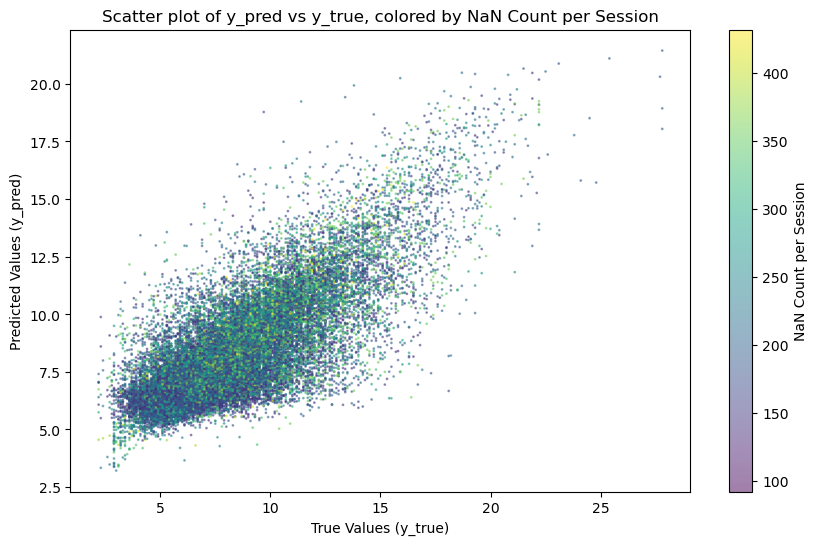

In [45]:
import matplotlib.pyplot as plt
import numpy as np




# Create a scatter plot
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
scatter = plt.scatter(y_true, y_pred, c=NaN_percent_reduced, cmap='viridis', s=1, alpha=0.5)

# Add a color bar to indicate the NaN count per session
cbar = plt.colorbar(scatter)
cbar.set_label('NaN Count per Session')

# Add labels and title
plt.xlabel('True Values (y_true)')
plt.ylabel('Predicted Values (y_pred)')
plt.title('Scatter plot of y_pred vs y_true, colored by NaN Count per Session')

# Show the plot
plt.show()


In [32]:
# Model Explanation
import shap
from sklearn.inspection import permutation_importance

/home/jmaes/miniconda3/envs/bioinfo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


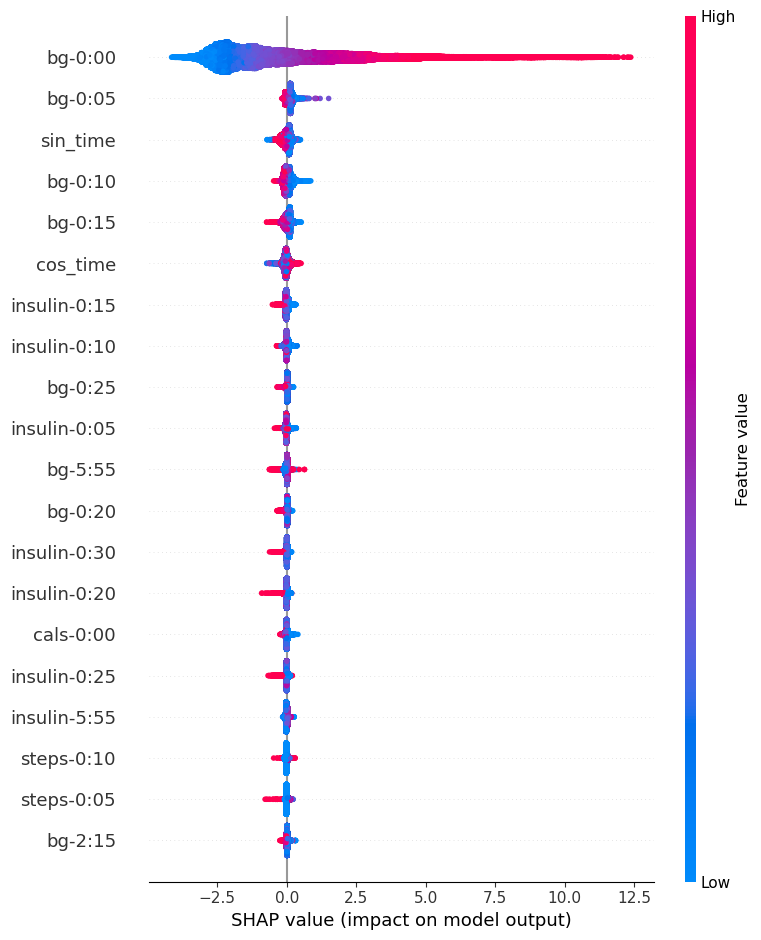

In [33]:
# Initialize the SHAP explainer
explainer = shap.Explainer(models[0])

# Calculate SHAP values for all instances
shap_values = explainer(X)

# Visualize global feature importance using summary plot
shap.summary_plot(shap_values, X)


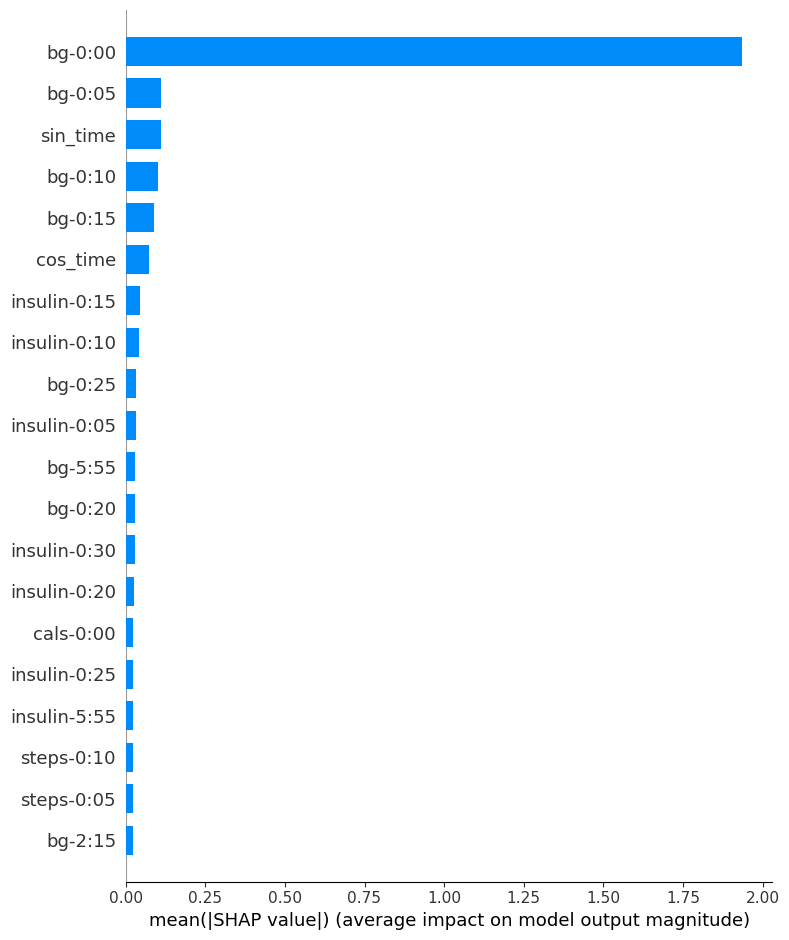

In [46]:
# Feature importance bar plot
shap.summary_plot(shap_values, X, plot_type="bar")

In [35]:
# # Force plot for a single prediction
# shap.force_plot(explainer.expected_value, shap_values[0], X_test[0])

# # Dependence plot for a single feature (e.g., feature 0)
# shap.dependence_plot(0, shap_values.values, X_test)

##################################################################

# DO the prediction on the test set

# Model Traing

In [36]:
X = train.drop(['hour','time_min', "id", "p_num", "time"],axis=1)
print(X.shape)

X_test = test.drop(['hour','time_min', "id", "p_num", "time"],axis=1)
print(X_test.shape)

(177024, 435)
(3644, 434)


In [37]:
y = train["bg+1:00"]
X = X.drop(columns=["bg+1:00"])

In [38]:
print(y.shape)
X.shape

(177024,)


(177024, 434)

In [39]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize list to store models and predictions
models = []
test_predictions = []
rmse_values_train = []
i = 1


# Define the custom scoring function (Root Mean Squared Error)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Use KFold for cross-validation
reset_seeds()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Train and store models, and make predictions
for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Train the model on the training set
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, enable_categorical=True)
    model.fit(X_train, y_train)
    models.append(model)
    model.save_model(f"models/model{i}.keras")
    i += 1

    # Save RMSE for the train set
    rmse_values_train.append(
        rmse(
            y_train, model.predict(X_train) 
        )
    )
    
    # Make predictions on the test set
    y_test_pred = model.predict(X_test)
    test_predictions.append(y_test_pred)
    
# Take the mean of predictions from all 5 models
final_predictions = np.mean(np.array(test_predictions), axis=0)

/home/jmaes/miniconda3/envs/bioinfo/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:22:28] WARNING: /croot/xgboost-split_1724073744422/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
/home/jmaes/miniconda3/envs/bioinfo/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:22:33] WARNING: /croot/xgboost-split_1724073744422/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
/home/jmaes/miniconda3/envs/bioinfo/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [19:22:38] WARNING: /croot/xgboost-split_1724073744422/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose

In [40]:
# check the performances on the train set
print(rmse_values_train)

[1.7651241216654434, 1.7598257570308928, 1.7687179852939596, 1.7604296390370842, 1.756299422321141]


In [41]:
# create the submission file
submission = pd.DataFrame()
submission['id'] = test['id']

# write the predictions
submission['bg+1:00'] = final_predictions

In [42]:
submission.head(20)

,id,bg+1:00
0,p01_8459,9.158422
1,p01_8460,6.145283
2,p01_8461,7.460898
3,p01_8462,9.815777
4,p01_8463,6.734019
5,p01_8464,6.519658
6,p01_8465,6.689018
7,p01_8466,9.183427
8,p01_8467,9.365446
9,p01_8468,6.461130


In [43]:
submission.to_csv('result/submission_xgboost.csv', index=False)

In [44]:
submission.shape

(3644, 2)